<a href="https://colab.research.google.com/github/ProEarth/602/blob/master/BART_Housing_Demo_Enhanced.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Decision Tree Implementation for BART Models
# A teaching example for understanding tree structures in Bayesian Additive Regression Trees

In [ ]:
# Install necessary packages as needed
# !pip install xarray matplotlib -q

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from typing import Optional, Union, List
import random

# Set random seed for reproducibility
np.random.seed(42)
random.seed(42)

# Part 1: Simple Tree Data Structure
# ---------------------------------

In [ ]:
class DecisionNode:
    """A node that makes a decision based on a feature value."""
    def __init__(self, feature_name: str, threshold: float):
        self.feature_name = feature_name
        self.threshold = threshold
        self.left = None  # For values <= threshold
        self.right = None  # For values > threshold

    def __str__(self):
        return f"Decision on {self.feature_name} at {self.threshold:.4f}"

In [ ]:
class LeafNode:
    """A leaf node that provides a prediction value."""
    def __init__(self, value: float):
        self.value = value

    def __str__(self):
        return f"Leaf with value {self.value:.4f}"

In [ ]:
class DecisionTree:
    """A decision tree that works with xarray datasets."""
    def __init__(self):
        self.root = None
        self.sample_dim = 'sample'

    def predict_single(self, x: xr.Dataset) -> float:
        """Predict for a single sample."""
        if self.root is None:
            raise ValueError("Tree hasn't been built yet")

        node = self.root
        while isinstance(node, DecisionNode):
            feature_value = float(x[node.feature_name].values)
            if feature_value <= node.threshold:
                node = node.left
            else:
                node = node.right

        return node.value

    def predict(self, X: xr.Dataset) -> xr.DataArray:
        """Predict for multiple samples."""
        predictions = np.zeros(len(X[self.sample_dim]))

        for i, sample_id in enumerate(X[self.sample_dim].values):
            sample = X.sel({self.sample_dim: sample_id})
            predictions[i] = self.predict_single(sample)

        return xr.DataArray(
            predictions,
            dims=[self.sample_dim],
            coords={self.sample_dim: X[self.sample_dim]}
        )

# Part 2: Tree Visualization
# --------------------------

In [ ]:
def visualize_tree(node, indent="", is_left=True, is_root=True):
    """Print a visual representation of the tree."""
    if node is None:
        return

    # Print current node
    prefix = "" if is_root else (indent + ("└── " if is_left else "┌── > "))
    print(prefix + str(node))

    # Only continue if we're at a decision node
    if isinstance(node, DecisionNode):
        # Set the new indent level for the children
        new_indent = indent + ("    " if is_left else "│   ")

        # Recursively print the left and right subtrees
        visualize_tree(node.left, new_indent, True, False)
        visualize_tree(node.right, new_indent, False, False)

# Part 3: Create Example Housing Dataset
# -------------------------------------

In [ ]:
def create_housing_dataset(n_samples=20):
    """Create a synthetic housing dataset for demonstration."""
    # Generate sample IDs
    samples = [f'house{i+1}' for i in range(n_samples)]

    # Generate feature values
    np.random.seed(42)  # For reproducibility
    sqft = np.random.uniform(800, 2500, n_samples).round()
    bedrooms = np.random.randint(1, 6, n_samples)
    age = np.random.uniform(0, 50, n_samples).round()
    location_score = np.random.uniform(1, 10, n_samples).round(1)

    # Generate prices based on features (with some noise)
    base_price = 100000
    sqft_factor = 100
    bedroom_factor = 15000
    age_factor = -1000
    location_factor = 10000

    prices = (
        base_price +
        sqft_factor * sqft +
        bedroom_factor * bedrooms +
        age_factor * age +
        location_factor * location_score +
        np.random.normal(0, 20000, n_samples)
    ).round()

    # Create the dataset
    ds = xr.Dataset(
        data_vars={
            'sqft': ('sample', sqft),
            'bedrooms': ('sample', bedrooms),
            'age': ('sample', age),
            'location_score': ('sample', location_score),
            'price': ('sample', prices)
        },
        coords={
            'sample': samples
        }
    )

    return ds

# Part 4: Create a Demo Tree
# -------------------------

In [ ]:
def create_demo_tree():
    """Create a simple decision tree for the housing example."""
    tree = DecisionTree()

    # Create root node (decision node)
    root = DecisionNode("sqft", 1500)

    # Create left branch (smaller houses)
    small_house = DecisionNode("bedrooms", 2)
    small_house.left = LeafNode(180000)  # Small house, few bedrooms
    small_house.right = LeafNode(220000)  # Small house, more bedrooms

    # Create right branch (larger houses)
    large_house = DecisionNode("age", 20)
    large_house.left = LeafNode(350000)  # Large, newer house
    large_house.right = LeafNode(300000)  # Large, older house

    # Connect to root
    root.left = small_house
    root.right = large_house

    # Set tree root
    tree.root = root

    return tree


# Part 5: Demonstration of Tree Usage
# ----------------------------------

In [ ]:
# Create our example dataset
housing_data = create_housing_dataset(20)

# Display first few samples
print("Housing Dataset (first 5 samples):")
print(housing_data.isel(sample=slice(0, 5)))

# Create our decision tree
demo_tree = create_demo_tree()

# Visualize the tree structure
print("\nDecision Tree Structure:")
visualize_tree(demo_tree.root)

# Make predictions
predictions = demo_tree.predict(housing_data)

# Combine with original data for comparison
housing_data['predicted_price'] = predictions

# Display predictions vs actual for first few samples
print("\nPredictions vs Actual Prices (first 5 samples):")
comparison = housing_data[['price', 'predicted_price']].to_array().to_pandas().T.head()
print(comparison)

Housing Dataset (first 5 samples):
<xarray.Dataset> Size: 340B
Dimensions:         (sample: 5)
Coordinates:
  * sample          (sample) <U7 140B 'house1' 'house2' ... 'house4' 'house5'
Data variables:
    sqft            (sample) float64 40B 1.437e+03 2.416e+03 ... 1.065e+03
    bedrooms        (sample) int64 40B 3 2 4 4 3
    age             (sample) float64 40B 1.0 12.0 12.0 34.0 30.0
    location_score  (sample) float64 40B 6.1 5.7 9.7 8.6 7.7
    price           (sample) float64 40B 3.627e+05 4.201e+05 ... 2.951e+05

Decision Tree Structure:
Decision on sqft at 1500.0000
    └── Decision on bedrooms at 2.0000
        └── Leaf with value 180000.0000
        ┌── > Leaf with value 220000.0000
    ┌── > Decision on age at 20.0000
    │   └── Leaf with value 350000.0000
    │   ┌── > Leaf with value 300000.0000

Predictions vs Actual Prices (first 5 samples):
variable     price  predicted_price
sample                             
house1    362669.0         220000.0
house2    420072.0  

# Part 6: Simple Plot of Results
# -----------------------------

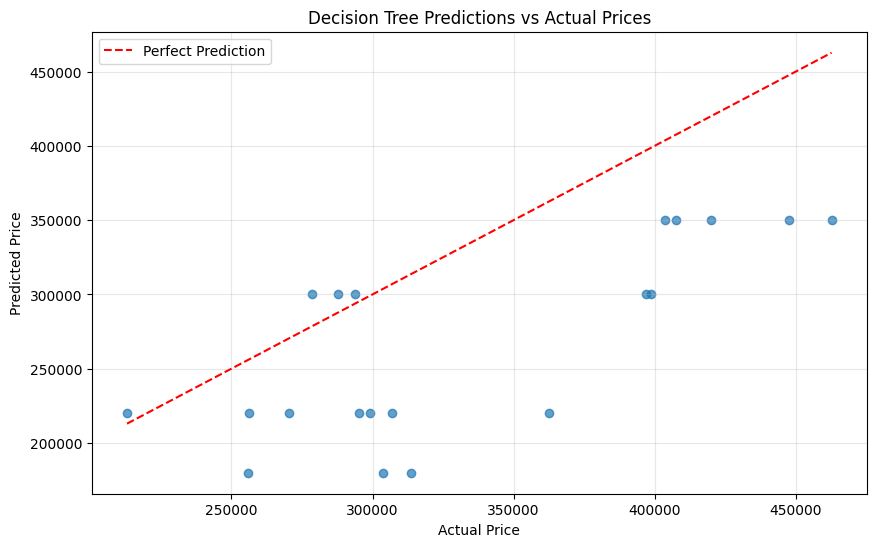

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(housing_data.price.values, predictions.values, alpha=0.7)
plt.plot([housing_data.price.min(), housing_data.price.max()],
         [housing_data.price.min(), housing_data.price.max()],
         'r--', label='Perfect Prediction')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Decision Tree Predictions vs Actual Prices')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Part 7: Tree Building Functions
# ------------------------------

In [ ]:
def calculate_mse(y_true, y_pred):
    """Calculate Mean Squared Error."""
    return np.mean((y_true - y_pred) ** 2)

def find_best_split(X, y, feature_names):
    """Find the best feature and threshold to split the data."""
    best_feature = None
    best_threshold = None
    best_mse = float('inf')

    # Try each feature
    for feature in feature_names:
        # Get unique values for potential thresholds
        values = np.unique(X[feature].values)

        # Skip if only one unique value
        if len(values) <= 1:
            continue

        # Try different thresholds between consecutive values
        for i in range(len(values) - 1):
            threshold = (values[i] + values[i + 1]) / 2

            # Split into left and right based on threshold
            left_mask = X[feature] <= threshold
            right_mask = ~left_mask

            # Skip if either side is empty
            if left_mask.sum() == 0 or right_mask.sum() == 0:
                continue

            # Calculate predictions for each side
            left_pred = y.where(left_mask, drop=True).mean().item()
            right_pred = y.where(right_mask, drop=True).mean().item()

            # Calculate MSE for this split (fixed by including 'sample' dimension)
            left_mse = calculate_mse(y.where(left_mask, drop=True).values, left_pred)
            right_mse = calculate_mse(y.where(right_mask, drop=True).values, right_pred)

            # Weighted average MSE
            mse = (
                left_mask.sum() * left_mse +
                right_mask.sum() * right_mse
            ) / len(y)

            # Update best if this is better
            if mse < best_mse:
                best_mse = mse
                best_feature = feature
                best_threshold = threshold

    return best_feature, best_threshold

def build_tree(X, y, feature_names, max_depth=3, min_samples_split=2, depth=0):
    """Build a decision tree recursively."""
    # Base case: stop if max depth reached or not enough samples
    if depth >= max_depth or len(y) < min_samples_split:
        return LeafNode(y.mean().item())

    # Find the best split
    best_feature, best_threshold = find_best_split(X, y, feature_names)

    # If no good split found, create a leaf node
    if best_feature is None:
        return LeafNode(y.mean().item())

    # Create a decision node
    node = DecisionNode(best_feature, best_threshold)

    # Split the data
    left_mask = X[best_feature] <= best_threshold
    right_mask = ~left_mask

    # Build the left and right subtrees
    node.left = build_tree(
        X.where(left_mask, drop=True),
        y.where(left_mask, drop=True),
        feature_names, max_depth, min_samples_split, depth + 1
    )

    node.right = build_tree(
        X.where(right_mask, drop=True),
        y.where(right_mask, drop=True),
        feature_names, max_depth, min_samples_split, depth + 1
    )

    return node

# Part 8: Build a Tree from Data
# -----------------------------

In [ ]:
# Choose features to use
features = ['sqft', 'bedrooms', 'age', 'location_score']

# Build a tree from our housing data
learned_tree = DecisionTree()
learned_tree.root = build_tree(
    housing_data[features],
    housing_data['price'],
    features,
    max_depth=3
)

# Visualize the learned tree
print("\nLearned Decision Tree Structure:")
visualize_tree(learned_tree.root)

# Make predictions using the learned tree
learned_predictions = learned_tree.predict(housing_data)

# Calculate MSE
mse = calculate_mse(housing_data['price'].values, learned_predictions.values)
print(f"\nMean Squared Error: {mse:.2f}")



Learned Decision Tree Structure:
Decision on sqft at 1755.0000
    └── Decision on location_score at 4.7000
        └── Decision on sqft at 972.0000
            └── Leaf with value 213017.0000
            ┌── > Leaf with value 267592.2500
        ┌── > Decision on age at 1.5000
        │   └── Leaf with value 362669.0000
        │   ┌── > Leaf with value 302012.6667
    ┌── > Decision on location_score at 1.8000
    │   └── Leaf with value 278612.0000
    │   ┌── > Decision on age at 16.0000
    │   │   └── Leaf with value 434455.0000
    │   │   ┌── > Leaf with value 399833.0000

Mean Squared Error: 144880912.00



# Part 9: Visualize the learned tree predictions
# --------------------------------------------

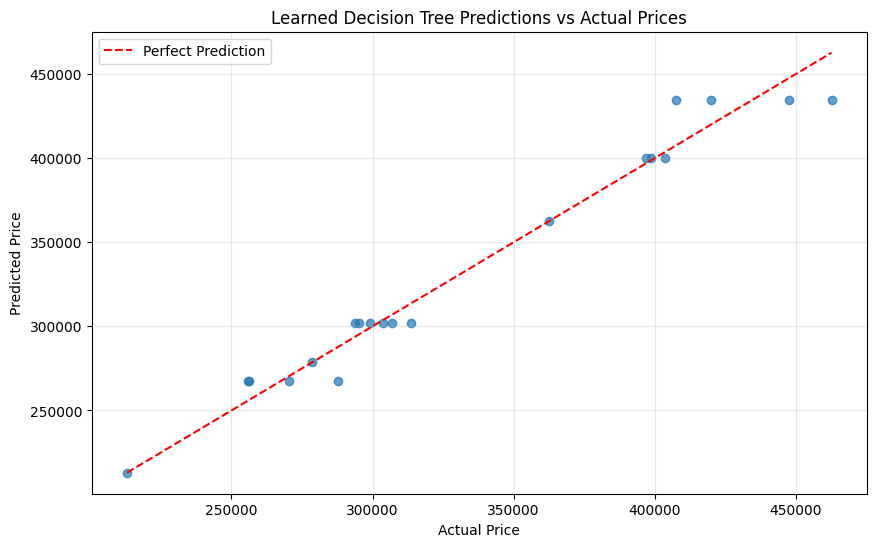

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(housing_data.price.values, learned_predictions.values, alpha=0.7)
plt.plot([housing_data.price.min(), housing_data.price.max()],
         [housing_data.price.min(), housing_data.price.max()],
         'r--', label='Perfect Prediction')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Learned Decision Tree Predictions vs Actual Prices')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


# Part 10 (YOUR TURN): This Week's Mimimum Next Steps Towards BART
# ------------------------------

Work Expectations:
* You will work hard from 6:00pm - 8:30pm during class and stay on task (not on your phone or distracted).
* You will work around 1-6 hours outside of class towards developing this solution.
* You will be prepared to be randomly called upon to discuss your progresss to-date in front of the class and what challenge you are tackling next?

Minimum Requirements For Week:
* go through the PYMC-BART Documentation: https://www.pymc.io/projects/bart/en/latest/
* make sure you can run PYMC-BART
* get PYMC_BART to run on the sample data above
* visualize the performance of PYMC-BART using the tools the developers suggest
* compare the simple toy model above's performance to PYMC-BART's performance.  


Future Requirements:
* Think about feature engineering for horse race prediction.  What are you predicting?  Will you have that data readily available on race day?  How are you training your BART model?  How will you convert multiple historical XML files into an xarray dataset for your features?
* Does a 2-stage BART model work where the first stage is individual BART models with limited subsets of available features using prior knowledge to create the "expert" models and the second stage is a BART model that combines the "Expert predictions.  Test on Friedman data and explore with horse racing data.
* Are you able to make predictions?  How can we as a class work together to make a class prediction?  What data should we be sharing?

HORSE RACING HISTORICAL DATA FOR TRAINING TO BE POSTED HERE:  https://github.com/flyaflya/fsan830spring2025/tree/main/data/sampleRaceResults


# 🧠 Part 11: PyMC-BART on the Sample Housing Dataset

In this section, we follow the assignment requirement to:

1. Use the existing synthetic housing dataset (`create_housing_dataset`) as input.
2. Run a real BART model using PyMC-BART.
3. Visualize the posterior predictive results.
4. Compare performance (R², RMSE) with our earlier hand-coded tree model.


In [2]:
!pip install -U numpy pymc pymc-bart arviz xarray matplotlib scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 518.9/518.9 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 39.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 102.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 92.4 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.4
    Uninstalling numpy-1.24.4:
      Successfully uninstalled numpy-1.24.4
  Attempting uninstall: xarray
    Found existing installation: xarray 2025.1.2
    Uninstalling xarray-2025.1.2:
      Successfully uninstalled xarray-2025.1.2
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.10.0
    Uninstalling matplotlib-3.10.0:
      Successfu

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
from pymc_bart import BART
from sklearn.metrics import r2_score, mean_squared_error

In [3]:
def create_housing_dataset(n_samples=20):
    """Create a synthetic housing dataset for demonstration."""
    # Generate sample IDs
    samples = [f'house{i+1}' for i in range(n_samples)]

    # Generate feature values
    np.random.seed(42)  # For reproducibility
    sqft = np.random.uniform(800, 2500, n_samples).round()
    bedrooms = np.random.randint(1, 6, n_samples)
    age = np.random.uniform(0, 50, n_samples).round()
    location_score = np.random.uniform(1, 10, n_samples).round(1)

    # Generate prices based on features (with some noise)
    base_price = 100000
    sqft_factor = 100
    bedroom_factor = 15000
    age_factor = -1000
    location_factor = 10000

    prices = (
        base_price +
        sqft_factor * sqft +
        bedroom_factor * bedrooms +
        age_factor * age +
        location_factor * location_score +
        np.random.normal(0, 20000, n_samples)
    ).round()

    # Create the dataset
    ds = xr.Dataset(
        data_vars={
            'sqft': ('sample', sqft),
            'bedrooms': ('sample', bedrooms),
            'age': ('sample', age),
            'location_score': ('sample', location_score),
            'price': ('sample', prices)
        },
        coords={
            'sample': samples
        }
    )

    return ds

In [ ]:
# Use the housing dataset from earlier
housing_data = create_housing_dataset(20)

X = np.stack([
    housing_data["sqft"].values,
    housing_data["bedrooms"].values,
    housing_data["age"].values,
    housing_data["location_score"].values
], axis=1)
Y = housing_data["price"].values

# Run BART model
with pm.Model() as bart_model:
    μ = BART("μ", X, Y, m=50)
    σ = pm.HalfNormal("σ", sigma=20000)
    y_obs = pm.Normal("y_obs", mu=μ, sigma=σ, observed=Y)
    trace = pm.sample(1000, tune=1000, chains=2, target_accept=0.95, random_seed=42)


Output()

In [ ]:

# Posterior predictive
# 后验预测（显式指定变量）
posterior_predictive = pm.sample_posterior_predictive(
    trace,
    model=bart_model,
    var_names=["μ"]  # 只抽样 BART 预测的中间变量 μ
)

# 计算预测均值
y_pred_mean = posterior_predictive["μ"].mean(axis=0)


# Visualization
plt.figure(figsize=(6, 6))
plt.scatter(Y, y_pred_mean, c="blue")
plt.plot([Y.min(), Y.max()], [Y.min(), Y.max()], 'k--')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("PyMC-BART Prediction vs Actual")
plt.grid(True)
plt.show()

# Print evaluation
r2 = r2_score(Y, y_pred_mean)
rmse = mean_squared_error(Y, y_pred_mean, squared=False)
print(f"R² Score: {r2:.4f}")
print(f"RMSE: {rmse:.2f}")
